In [10]:
from lifelines import WeibullAFTFitter
import pandas as pd

In [29]:
df=pd.read_csv('tele_churn.csv')

In [30]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [31]:
## Convert TotalCharges to numeric
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')

## Replace yes and No in the Churn column to 1 and 0. 1 for the event and 0 for the censured data.
df['Churn']=df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0 )

In [35]:
## Impute the null value with the median value

df.TotalCharges.fillna(value=df['TotalCharges'].median(),inplace=True)


## Create a list of Categorical Columns
cat_cols= [i  for i in df.columns if df[i].dtype==object]
cat_cols.remove('customerID')  ## customerID has been removed because it is unique for all the rows.

# Ensure 'tenure' has no non-positive values
df['tenure'] = df['tenure'].apply(lambda x: x if x > 0 else 0.01)



C:\Users\Arth\AppData\Local\Temp\ipykernel_16308\2784317480.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.TotalCharges.fillna(value=df['TotalCharges'].median(),inplace=True)


In [36]:
durations = df['tenure'] ## Time to event data of censored and event data
event_observed = df['Churn']  ## It has the churned (1) and censored is (0)

In [37]:
df_r= df.loc[:,['tenure','Churn','gender','Partner','Dependents','PhoneService','MonthlyCharges','SeniorCitizen','StreamingTV']]
df_r.head() ## have a look at the data 

,tenure,Churn,gender,Partner,Dependents,PhoneService,MonthlyCharges,SeniorCitizen,StreamingTV
0,1.0,0,Female,Yes,No,No,29.85,0,No
1,34.0,0,Male,No,No,Yes,56.95,0,No
2,2.0,1,Male,No,No,Yes,53.85,0,No
3,45.0,0,Male,No,No,No,42.30,0,No
4,2.0,1,Female,No,No,Yes,70.70,0,No


In [38]:
## Create dummy variables
df_dummy = pd.get_dummies(df_r, drop_first=True, dtype=int)
df_dummy.head(100)

,tenure,Churn,MonthlyCharges,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,StreamingTV_No internet service,StreamingTV_Yes
0,1.0,0,29.85,0,0,1,0,0,0,0
1,34.0,0,56.95,0,1,0,0,1,0,0
2,2.0,1,53.85,0,1,0,0,1,0,0
3,45.0,0,42.30,0,1,0,0,0,0,0
4,2.0,1,70.70,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
95,12.0,1,78.95,0,0,0,0,1,0,0
96,71.0,0,66.85,0,1,1,1,1,0,0
97,5.0,1,21.05,0,1,0,0,1,1,0
98,52.0,0,21.00,0,1,0,0,1,1,0


In [39]:
# Using Cox Proportional Hazards model
cph = WeibullAFTFitter()   ## Instantiate the class to create a cph object
cph.fit(df_dummy, 'tenure', event_col='Churn')   ## Fit the data to train the model
cph.print_summary()    ## HAve a look at the significance of the features

<lifelines.WeibullAFTFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
   number of observations = 7043
number of events observed = 1869
           log-likelihood = -10101.24
         time fit was run = 2025-02-03 07:39:50 UTC

---
                                         coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                                        
lambda_ Dependents_Yes                   0.51      1.67      0.10            0.32            0.70                1.38                2.02
        MonthlyCharges                   0.02      1.02      0.00            0.01            0.02                1.01                1.02
        Partner_Yes                      1.14      3.13      0.08            0.99            1.29                2.69                3.64
        PhoneService_Yes                -1.02      0.36      0.15           -1.31           -0.73                0.27                0.48
        SeniorCitizen                   -0.55      0.57      0.08           -0.71           -0.40                0.49                0.67
        StreamingTV_No internet service  3.02     20.42      0.19            2.64            3.39               13.99               29.80
        StreamingTV_Yes                  0.26      1.30      0.09            0.09            0.44                1.10                1.55
        gender_Male                      0.01      1.01      0.07           -0.12            0.14                0.89                1.15
        Intercept                        3.94     51.17      0.15            3.65            4.23               38.29               68.39
rho_    Intercept                       -0.35      0.70      0.02           -0.39           -0.31                0.68                0.73

                                         cmp to      z      p  -log2(p)
param   covariate                                                      
lambda_ Dependents_Yes                     0.00   5.24 <0.005     22.59
        MonthlyCharges                     0.00   6.49 <0.005     33.43
        Partner_Yes                        0.00  14.76 <0.005    161.32
        PhoneService_Yes                   0.00  -6.88 <0.005     37.31
        SeniorCitizen                      0.00  -6.99 <0.005     38.40
        StreamingTV_No internet service    0.00  15.64 <0.005    180.75
        StreamingTV_Yes                    0.00   3.04 <0.005      8.71
        gender_Male                        0.00   0.18   0.86      0.22
        Intercept                          0.00  26.60 <0.005    515.34
rho_    Intercept                          0.00 -17.36 <0.005    221.89
---
Concordance = 0.71
AIC = 20222.48
log-likelihood ratio test = 950.13 on 8 df
-log2(p) of ll-ratio test = 661.27

<Axes: xlabel='log(accelerated failure rate) (95% CI)'>

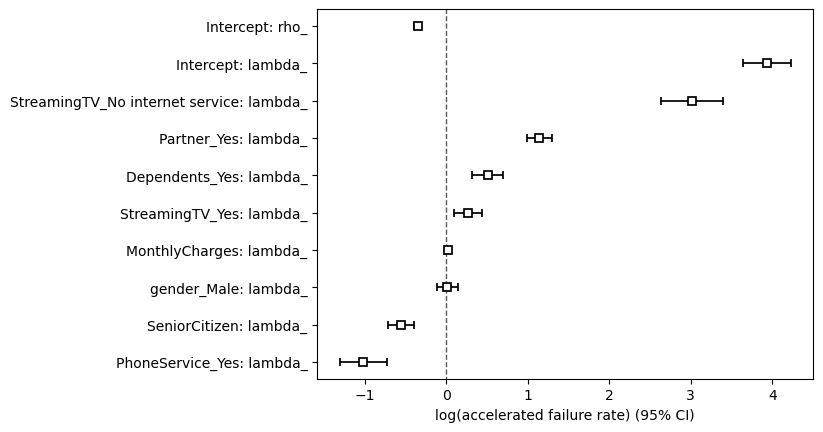

In [40]:
cph.plot()

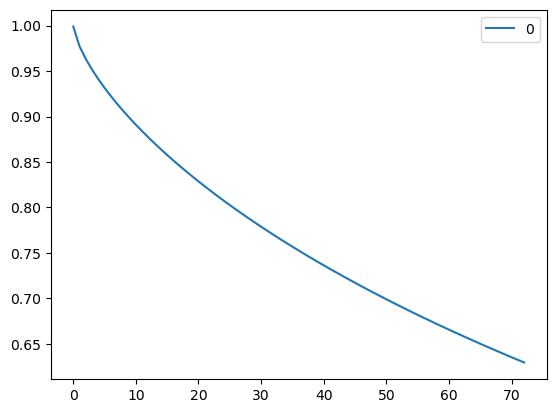

In [ ]:
data_1= {
    'tenure': [1],
    'MonthlyCharges': [29.85],                       #Non-Churn Data
    'SeniorCitizen': [0],
    'gender_Male': [0],
    'Partner_Yes': [1],
    'Dependents_Yes': [0],
    'PhoneService_Yes': [0],
    'StreamingTV_No internet service': [0],
    'StreamingTV_Yes': [0],
}


#Churn
data_2= {
    'tenure': [25],
    'MonthlyCharges': [98.50],
    'SeniorCitizen': [1],                                                
    'gender_Male': [0],
    'Partner_Yes': [1],                                    
    'Dependents_Yes': [0],
    'PhoneService_Yes': [1],
    'StreamingTV_No internet service': [0],
    'StreamingTV_Yes': [1],
}

original_df = pd.DataFrame(data_2)
#print(original_df.head())
data= cph.predict_survival_function(original_df).plot(label= "Predicted")
print()


In [55]:
# Predictions and analysis functions
def predict_cumulative_hazard(X, times):
    return cph.predict_cumulative_hazard(X, times=times)

def predict_expectation(X):
    return cph.predict_expectation(X)

def predict_log_partial_hazard(X):
    return cph.predict_log_partial_hazard(X)

def predict_partial_hazard(X):
    return cph.predict_partial_hazard(X)

def predict_median(X):
    return cph.predict_median(X)

def predict_percentile(X):
    return cph.predict_percentile(X)

def predict_survival_function(X, times):
    return cph.predict_survival_function(X, times=times)

def score_model(df):
    return cph.score(df)

# Example usage with reference data and specific times
times = [10, 20, 30, 40]

print("Cumulative Hazard:\n", predict_cumulative_hazard(original_df, times))
print("Expected Time:\n", predict_expectation(original_df))
#print("Log Partial Hazard:\n", predict_log_partial_hazard(original_df))
#print("Partial Hazard:\n", predict_partial_hazard(original_df))
print("Median Time:\n", predict_median(original_df))
print("25th Percentile Time:\n", predict_percentile(original_df))
print("Survival Function:\n", predict_survival_function(original_df, times))
#print("Model Score:\n", score_model(df_dummy))




print("Expectation_Prediction: ",cph.predict_expectation(original_df))

Cumulative Hazard:
              0
10.0  0.115361
20.0  0.187906
30.0  0.249967
40.0  0.306071
Expected Time:
 0    270.827913
dtype: float64
Median Time:
 0    127.771052
dtype: float64
25th Percentile Time:
 0    127.771052
dtype: float64
Survival Function:
              0
10.0  0.891044
20.0  0.828692
30.0  0.778826
40.0  0.736335
Expectation_Prediction:  0    270.827913
dtype: float64


In [56]:
concordance_index = cph.concordance_index_
print(concordance_index)

0.711232811617372
